In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm # progress bar for loops, interrupt if needed
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
import os
import glob
from labellines import *


divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 20.
nbins = 64
mmax = 10
nmax = 1

noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm # progress bar for loops, interrupt if needed
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
import os
import glob
from labellines import *




divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 20.
nbins = 64
mmax = 10
nmax = 2

noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

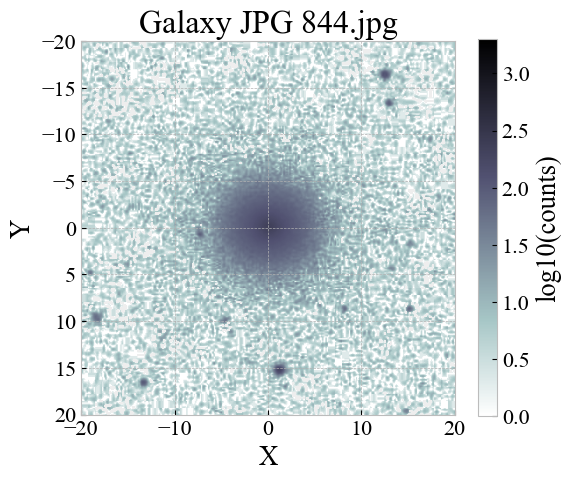

Amn (rows = n, columns = m):
[[0.153 0.001 0.    0.    0.    0.    0.001 0.    0.    0.    0.   ]
 [0.043 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
[[ 1.52660085e-01  4.30169602e-02]
 [-1.35776294e-04  3.46809443e-04]
 [-6.85862696e-05 -1.67134486e-06]
 [ 2.36889697e-04 -1.11538088e-04]
 [ 2.76083159e-04 -3.49088189e-05]
 [ 5.55124113e-05 -1.44925168e-04]
 [ 6.63185471e-04  3.49231069e-04]
 [-3.30780781e-04 -1.22175601e-04]
 [-1.68344946e-04 -2.25013198e-04]
 [-1.37236265e-04 -1.18711858e-04]
 [-5.67275157e-05  2.95346624e-05]] [[ 0.00000000e+00  0.00000000e+00]
 [ 5.99872323e-04  2.86599229e-04]
 [-2.78658121e-04 -1.46710345e-04]
 [ 5.32457816e-05 -5.02780330e-06]
 [ 2.38084180e-04  1.37047195e-04]
 [-2.11179985e-04 -4.23872580e-04]
 [ 2.68245992e-04  2.36468084e-04]
 [-2.83965271e-04 -1.02690953e-04]
 [ 2.31502499e-04  5.29693589e-05]
 [ 2.42394043e-05 -3.14634302e-04]
 [ 5.64274381e-05  3.28221524e-04]]


Processing inclinations: 100%|██████████| 8/8 [04:16<00:00, 32.07s/inclination]

0.0022163788825510164 -0.0003590488313687647


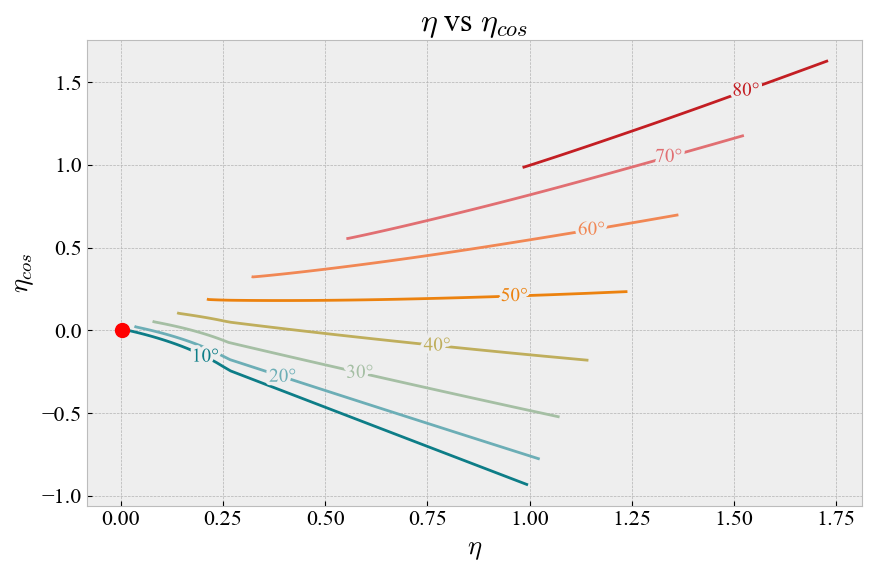

In [60]:
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt

file="844.jpg"  # replace with your image file
img_pil = Image.open(file).convert("L")
w, h    = img_pil.size

img_incl = np.array(img_pil, dtype=float)

x_edges = np.linspace(-rmax, rmax, w+1)
y_edges = np.linspace(rmax, -rmax, h+1)

safe     = np.where(img_incl>0, img_incl, np.nan)
log_img  = np.log10(safe)

plt.figure(figsize=(6,5))
plt.imshow(
    log_img, origin="lower", cmap="bone_r",
    extent=[x_edges[0],x_edges[-1],y_edges[0],y_edges[-1]],
    vmin=0, vmax=3.3
)
plt.colorbar(label="log10(counts)")
plt.title(f"Galaxy JPG {file}")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

D = DiscGalaxy(N=N, a=a)
D.img     = img_incl
D.x_edges = x_edges
D.y_edges = y_edges

E1 = D.make_pointexpansion(mmax, nmax, a*1.5, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)



coscoefstrue = E1.coscoefs
sincoefstrue = E1.sincoefs

Amn = np.sqrt(coscoefstrue**2 +sincoefstrue**2) 

Amn_matrix = Amn.T 

print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,3)) 
print(coscoefstrue, sincoefstrue)


# the grid of inclinations to draw curves for:
incl_list = np.linspace(10, 80, 8)     # eight sample inclinations
PA_list   = np.linspace(0, 80, 41)     # fine PA sampling
colorindx = np.linspace(0, 1, len(incl_list+1))  # color index for inclinations
plt.figure(figsize=(9, 6))



i=0
for inc in tqdm(incl_list, desc="Processing inclinations", unit="inclination"):
    etas      = []
    eta_cos = []
    for PA in PA_list:
        # generate the galaxy
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(inc, PA, 0)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a*1.5)

        c = E.coscoefs; s = E.sincoefs

        num_cos = sum(c[2,n] for n in range(nmax))
        num_sin = sum(s[2,n] for n in range(nmax))
        num     = sum(np.hypot(c[2,n], s[2,n]) for n in range(nmax))
        den     = sum(abs(c[0,n])            for n in range(nmax))

        eta     = num/den if den else np.nan
        etacos  = num_cos/den if den else np.nan
        

        etas.append(eta)
        eta_cos.append(etacos) 

    # plot one curve (inc fixed, PA varying)
    plt.plot(etas, eta_cos, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))
    i += 1
    
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\eta_{cos}$")
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.title(r"$\eta$ vs $\eta_{cos}$")
plt.grid(True)

# now do the blind test and overplot a big marker


num_cos = sum(coscoefstrue[2,n] for n in range(nmax))

num     = sum(np.hypot(coscoefstrue[2,n], sincoefstrue[2,n]) for n in range(nmax))
den     = sum(abs(coscoefstrue[0,n])            for n in range(nmax))

eta_bt     = num/den
eta_cos_bt = num_cos/den


# big red dot
plt.plot(eta_bt, eta_cos_bt, 'o', color='red', markersize=10, label="Blind Test")
print(eta_bt, eta_cos_bt)
plt.tight_layout()
plt.show()

